<a href="https://colab.research.google.com/github/Swati-Yadv/Blockchain/blob/master/MultilabelClassification_CVE2ATT%26CK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multilabel Classification on https://github.com/readerbench/CVE2ATT-CK-tactics/tree/main/data

In [2]:
# Installing the required libraries
!pip install transformers datasets torch seaborn matplotlib scikit-learn

In [3]:
import numpy as np
import pandas as pd

In [4]:
# Loading the datasets
df = pd.read_csv('/content/train_1.csv', encoding='latin-1')

In [5]:
# Labels(Tactic Labels)
print(df.columns[1:])

Index(['Text', 'Reconnaissance', 'Resource Development', 'Initial Access',
       'Execution', 'Persistence', 'Privilege Escalation', 'Defense Evasion',
       'Credential Access', 'Discovery', 'Lateral Movement', 'Collection',
       'Command and Control', 'Exfiltration', 'Impact'],
      dtype='object')


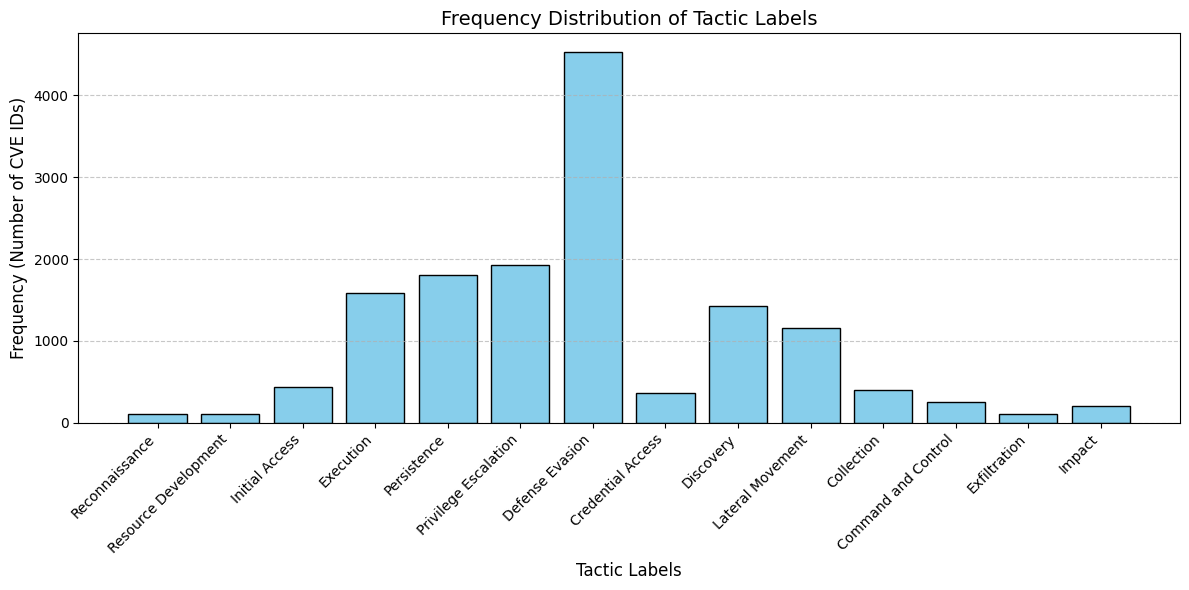

In [6]:
import matplotlib.pyplot as plt

# List of tactic labels
tactic_labels = ['Reconnaissance', 'Resource Development', 'Initial Access', 'Execution',
                 'Persistence', 'Privilege Escalation', 'Defense Evasion',
                 'Credential Access', 'Discovery', 'Lateral Movement', 'Collection',
                 'Command and Control', 'Exfiltration', 'Impact']

# Calculate the frequency distribution
frequency_distribution = df[tactic_labels].sum()

# Plot the frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(frequency_distribution.index, frequency_distribution.values, color='skyblue', edgecolor='black')
plt.xlabel('Tactic Labels', fontsize=12)
plt.ylabel('Frequency (Number of CVE IDs)', fontsize=12)
plt.title('Frequency Distribution of Tactic Labels', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [7]:
# Dropping the first column 'ID'
df_modified = df.drop(columns=['ID'])


In [8]:
# Splitting into train, validation and test sets
from sklearn.model_selection import train_test_split

# Extract input text and labels
texts = df_modified['Text'].tolist()
# Assuming tactic IDs start from the second column and are numeric
# Convert the columns to numeric, errors='coerce' will handle non-numeric values
labels = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values

# Check if stratified splitting is possible
min_class_counts = labels.sum(axis=0).min()
if min_class_counts < 2:
    print(f"Some classes have fewer than 2 samples (min count: {min_class_counts}). Using random splitting.")

# Perform splitting
train_text, temp_text, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=0  # Random split for train/temporary split
)

# Split the temporary set into validation and test sets
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, test_size=0.5, random_state=0  # Random split for validation/test
)

# Print the sizes of each set
print(f"Train set size: {len(train_text)}")
print(f"Validation set size: {len(val_text)}")
print(f"Test set size: {len(test_text)}")

Some classes have fewer than 2 samples (min count: 0.0). Using random splitting.
Train set size: 4811
Validation set size: 601
Test set size: 602


In [9]:
# Converting data to Hugging Face dataset format
from datasets import Dataset
train_dataset = Dataset.from_dict({'text': train_text, 'labels': train_labels.tolist()})
val_dataset = Dataset.from_dict({'text': val_text, 'labels': val_labels.tolist()})
test_dataset = Dataset.from_dict({'text': test_text, 'labels': test_labels.tolist()})

In [10]:
# Loading tokenizer and model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
model_name = 'markusbayer/CySecBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=labels.shape[1])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at markusbayer/CySecBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Tokenizing Data
def preprocess_data(examples):
  encoding = tokenizer(examples['text'], truncation=True, padding=True, max_length=512)
  encoding['labels'] = examples['labels']
  return encoding

train_dataset = train_dataset.map(preprocess_data, batched=True)
val_dataset = val_dataset.map(preprocess_data, batched=True)
test_dataset = test_dataset.map(preprocess_data, batched=True)

# Set format for Pytorch Tensors
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/4811 [00:00<?, ? examples/s]

Map:   0%|          | 0/601 [00:00<?, ? examples/s]

Map:   0%|          | 0/602 [00:00<?, ? examples/s]

In [12]:
# Define training arguments
training_args = TrainingArguments(
    output_dir = './results',
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    num_train_epochs = 5,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_loss',
    logging_strategy="epoch",  # or "steps"
    logging_steps=100,  # log every 100 steps (if using logging_strategy="steps")
    logging_dir="./logs", # directory to save logs
)

In [13]:
# Define Trainer
import torch
def compute_metrics(pred):
  logits, labels = pred
  logits = torch.sigmoid(torch.tensor(logits))
  predictions = (logits>0.5).int()
  true_positives = (predictions * labels).sum(axis=0).float()
  false_positives = (predictions * (1-labels)).sum(axis=0).float()
  false_negatives = ((1-predictions) * labels).sum(axis=0).float()
  true_negatives = ((1-predictions) * (1-labels)).sum(axis=0).float()

  precision = true_positives / (true_positives + false_positives + 1e-7)
  recall = true_positives / (true_positives + false_negatives + 1e-7)
  f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
  accuracy = (predictions == labels).float().mean()

  return{
      'precision': precision.tolist(),
      'recall': recall.tolist(),
      'f1': f1.tolist(),
      'accuracy': accuracy.item()
  }


In [14]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        How the loss is computed by Trainer. By default, all outputs of
        the model are passed to the loss function as returned by the model.

        Override this to adapt the loss function to the model's outputs and labels.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        logits = outputs.logits  # Assuming your model outputs logits under the 'logits' key
        # Change the loss function to BCEWithLogitsLoss which expects raw logits and integer labels
        loss_fct = torch.nn.BCEWithLogitsLoss()
        # Instead of reshaping, calculate the loss for each item in the batch separately.
        # This handles variable sequence lengths correctly.
        loss = 0
        for i in range(logits.shape[0]): # Iterate over batch size
            # Extract logits and labels for the current item
            item_logits = logits[i, :len(labels[i])]
            item_labels = labels[i]
            # Ignore -100 in labels (usually used for padding) when calculating loss
            # Only consider the actual tokens, not the padding tokens
            active_loss = item_labels.view(-1) != -100
            item_logits = item_logits[active_loss]
            item_labels = labels[i][active_loss].type(torch.float) # Cast item_labels to float
            # Check if there are any active tokens for this item before calculating loss
            if len(item_labels) > 0:
                # Accumulate the loss for each item in the batch
                loss += loss_fct(item_logits, item_labels)

        # Average the loss across the batch size
        loss /= logits.shape[0]
        return (loss, outputs) if return_outputs else loss

In [15]:
trainer = CustomTrainer(
      model = model,
      args = training_args,
      train_dataset = train_dataset,
      eval_dataset = val_dataset,
      compute_metrics = compute_metrics
  )

In [16]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: swatidhawana (swatidhawana-central-university-of-rajasthan). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.267100,0.203365,"[0.0, 0.0, 0.0, 0.0, 0.7685950398445129, 0.8285714387893677, 0.8166666626930237, 0.8886597752571106, 0.0, 0.8448275923728943, 0.7685950398445129, 0.75, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.5705521702766418, 0.8011049628257751, 0.765625, 0.9451754093170166, 0.0, 0.653333306312561, 0.7948718070983887, 0.07692307978868484, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.654929518699646, 0.8146067261695862, 0.7903225421905518, 0.916046679019928, 0.0, 0.7368420958518982, 0.7815126180648804, 0.1395348757505417, 0.0, 0.0, 0.0]",0.928785
2,0.182500,0.191835,"[0.0, 0.0, 1.0, 0.0, 0.7638888955116272, 0.8087431788444519, 0.7978723645210266, 0.885947048664093, 0.7037037014961243, 0.8442623019218445, 0.7637795209884644, 0.6818181872367859, 0.6499999761581421, 1.0, 0.0]","[0.0, 0.0, 0.5, 0.0, 0.6748466491699219, 0.8176795840263367, 0.78125, 0.9539473652839661, 0.5, 0.6866666674613953, 0.8290598392486572, 0.38461539149284363, 0.5652173757553101, 0.30000001192092896, 0.0]","[0.0, 0.0, 0.6666666269302368, 0.0, 0.7166123986244202, 0.813186764717102, 0.7894737124443054, 0.9186905026435852, 0.5846153497695923, 0.7573528289794922, 0.7950819134712219, 0.49180322885513306, 0.6046510934829712, 0.4615384638309479, 0.0]",0.933888
3,0.147000,0.188341,"[0.0, 0.0, 1.0, 0.692307710647583, 0.7289156913757324, 0.8054053783416748, 0.7938144207000732, 0.8944099545478821, 0.7037037014961243, 0.8206896781921387, 0.7461538314819336, 0.6399999856948853, 0.625, 1.0, 0.0]","[0.0, 0.0, 0.625, 0.20454545319080353, 0.7423312664031982, 0.8232043981552124, 0.8020833134651184, 0.9473684430122375, 0.5, 0.7933333516120911, 0.8290598392486572, 0.41025641560554504, 0.6521739363670349, 0.699999988079071, 0.0]","[0.0, 0.0, 0.7692307233810425, 0.31578943133354187, 0.735562264919281, 0.8142076134681702, 0.7979273796081543, 0.9201277494430542, 0.5846153497695923, 0.8067796230316162, 0.7854250073432922, 0.4999999403953552, 0.6382977962493896, 0.8235293030738831, 0.0]",0.935885
4,0.124000,0.197717,"[0.0, 0.0, 1.0, 0.4285714328289032, 0.7117646932601929, 0.737089216709137, 0.7252252101898193, 0.8924949169158936, 0.6774193644523621, 0.8467153310775757, 0.720588207244873, 0.5925925970077515, 0.5769230723381042, 1.0, 0.5]","[0.0, 0.0, 0.375, 0.06818182021379471, 0.7423312664031982, 0.8674033284187317, 0.8385416865348816, 0.9649122953414917, 0.5526315569877625, 0.7733333110809326, 0.8376068472862244, 0.41025641560554504, 0.6521739363670349, 0.6000000238418579, 0.0357142873108387]","[0.0, 0.0, 0.5454545021057129, 0.11764704436063766, 0.7267266511917114, 0.7969542741775513, 0.7777777314186096, 0.9272918105125427, 0.6086956262588501, 0.8083622455596924, 0.7747034430503845, 0.4848484396934509, 0.6122448444366455, 0.7499999403953552, 0.06666665524244308]",0.931669
5,0.107900,0.193031,"[0.0, 0.0, 1.0, 0.5714285969734192, 0.7532467246055603, 0.7903226017951965, 0.7743589878082275, 0.8979166746139526, 0.6666666865348816, 0.8382353186607361, 0.7580645084381104, 0.5925925970077515, 0.5769230723381042, 1.0, 0.3333333432674408]","[0.0, 0.0, 0.625, 0.1818181872367859, 0.7116564512252808, 0.8121547102928162, 0.7864583134651184, 0.9451754093170166, 0.5789473652839661, 0.7599999904632568, 0.8034188151359558, 0.41025641560554504, 0.6521739363670349, 0.6000000238418579, 0.0357142873108387]","[0.0, 0.0, 0.7692307233810425, 0.27586203813552856, 0.7318611741065979, 0.801089882850647, 0.7803617119789124, 0.920940101146698, 0.6197182536125183, 0.7972027659416199, 0.7800829410552979, 0.4848484396934509, 0.6122448444366455, 0.7499999403953552, 0.0645161122083664]",0.933888


Trainer is attempting to log a value of "[0.0, 0.0, 0.0, 0.0, 0.7685950398445129, 0.8285714387893677, 0.8166666626930237, 0.8886597752571106, 0.0, 0.8448275923728943, 0.7685950398445129, 0.75, 0.0, 0.0, 0.0]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.0, 0.0, 0.0, 0.0, 0.5705521702766418, 0.8011049628257751, 0.765625, 0.9451754093170166, 0.0, 0.653333306312561, 0.7948718070983887, 0.07692307978868484, 0.0, 0.0, 0.0]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.0, 0.0, 0.0, 0.0, 0.654929518699646, 0.8146067261695862, 0.7903225421905518, 0.916046679019928, 0.0, 0.7368420958518982, 0.7815126180648804, 0.1395348757505417, 0.0, 0.0, 0.0]" of type <class 'list'> for key "eval/f1" as a 

TrainOutput(global_step=3010, training_loss=0.1656956568112801, metrics={'train_runtime': 3473.4532, 'train_samples_per_second': 6.925, 'train_steps_per_second': 0.867, 'total_flos': 6329875184593920.0, 'train_loss': 0.1656956568112801, 'epoch': 5.0})

In [17]:
# Save the fine-tuned model
model.save_pretrained("./fine_tuned_cysecbert")
tokenizer.save_pretrained("./fine_tuned_cysecbert")

('./fine_tuned_cysecbert/tokenizer_config.json',
 './fine_tuned_cysecbert/special_tokens_map.json',
 './fine_tuned_cysecbert/vocab.txt',
 './fine_tuned_cysecbert/added_tokens.json',
 './fine_tuned_cysecbert/tokenizer.json')

In [18]:
# Get predictions from the model
predictions = trainer.predict(val_dataset)

# Extract the predicted labels (assuming your model outputs logits)
# Get predicted probabilities for all classes
predicted_probs = torch.sigmoid(torch.tensor(predictions.predictions))
# Assign label 1 if probability > 0.5, otherwise 0
predicted_labels = (predicted_probs > 0.5).int().cpu().numpy()
# Get the true labels for the validation dataset
labels = val_dataset['labels'] # Assuming 'labels' is the key for labels in your dataset
# Compute metrics
metrics = compute_metrics((predicted_labels, labels))

# Print the aggregated metrics
print("Evaluation Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision (per label): {metrics['precision']}")
print(f"Recall (per label): {metrics['recall']}")
print(f"F1-score (per label): {metrics['f1']}")

# Optionally, calculate averages (e.g., macro-average)
precision_avg = sum(metrics['precision']) / len(metrics['precision'])
recall_avg = sum(metrics['recall']) / len(metrics['recall'])
f1_avg = sum(metrics['f1']) / len(metrics['f1'])
print("\nMacro-Averaged Metrics:")
print(f"Precision: {precision_avg:.4f}")
print(f"Recall: {recall_avg:.4f}")
print(f"F1-score: {f1_avg:.4f}")

Evaluation Metrics:
Accuracy: 0.9359
Precision (per label): [0.0, 0.0, 1.0, 0.692307710647583, 0.7289156913757324, 0.8054053783416748, 0.7938144207000732, 0.8944099545478821, 0.7037037014961243, 0.8206896781921387, 0.7461538314819336, 0.6399999856948853, 0.625, 1.0, 0.0]
Recall (per label): [0.0, 0.0, 0.625, 0.20454545319080353, 0.7423312664031982, 0.8232043981552124, 0.8020833134651184, 0.9473684430122375, 0.5, 0.7933333516120911, 0.8290598392486572, 0.41025641560554504, 0.6521739363670349, 0.699999988079071, 0.0]
F1-score (per label): [0.0, 0.0, 0.7692307233810425, 0.31578943133354187, 0.735562264919281, 0.8142076134681702, 0.7979273796081543, 0.9201277494430542, 0.5846153497695923, 0.8067796230316162, 0.7854250073432922, 0.4999999403953552, 0.6382977962493896, 0.8235293030738831, 0.0]

Macro-Averaged Metrics:
Precision: 0.6300
Recall: 0.5353
F1-score: 0.5661


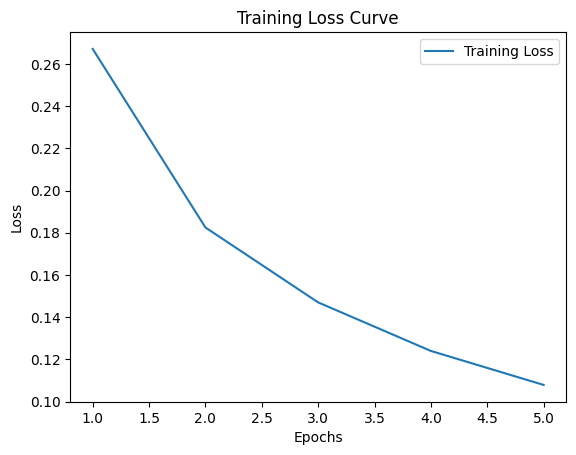

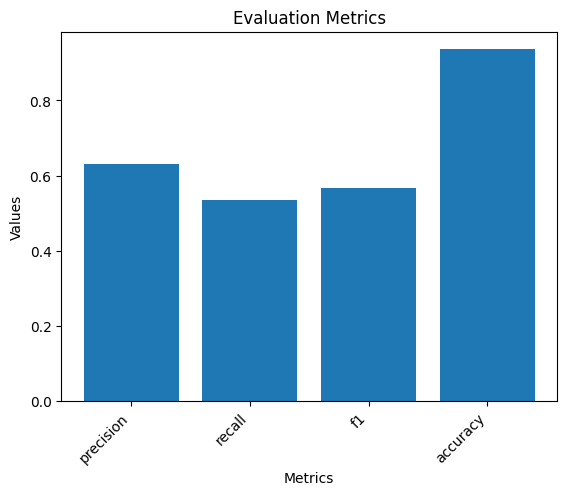

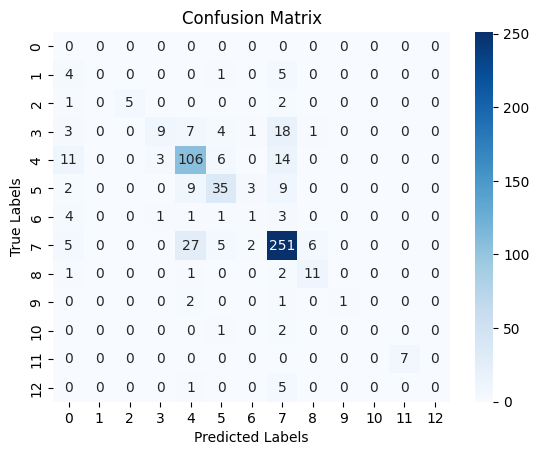

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have 'trainer' and 'predictions' from your previous code

# 1. Training Progress Plot
# Accessing training loss from the log history (assuming it's a list of dictionaries)
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
# The above line iterates through the log_history list and extracts the 'loss' value
# if it exists in the current log dictionary.

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# 2. Evaluation Metrics Plot/Table
# (Assuming you have already calculated metrics using 'compute_metrics')
metrics = compute_metrics((predicted_labels, labels))
# Convert list values to single values (e.g., average) for plotting
plot_metrics = {k: np.mean(v) if isinstance(v, (list, np.ndarray)) else v
                 for k, v in metrics.items()}

plt.bar(plot_metrics.keys(), plot_metrics.values())
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Evaluation Metrics')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

# 3. Confusion Matrix
# Assuming predicted_labels and labels are multi-class and need to be converted to 1D
cm = confusion_matrix(np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()